# HHL algorithm for solving linear equations
In the following notebook, we are going to let a real quantum device solve a linear system $A\vec x = \vec b$ .
We will use a quantum algorithm that was proposed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd in 2008.
Very simplified, one can distinguish 4 main steps that need to be performed on our quantum device:
1. Express the solution vector $\vec b$ as a quantum state $|b\rangle$ on a register
2. Use Quantum Phase Estimation (QPE) to decompose $|b\rangle$ into eigenvectors of A and obtain A's eigenvalues
3. Invert the (in the eigenvector base, diagonal) matrix A to prepare the state $A^{-1}|b\rangle$ = $|x\rangle$
4. Apply a linear operator M to $|x\rangle$ to obtain information on the solution vector $\vec x$

Be reminded that in the general case, the entries of $\vec x$ can not be efficiently read out because we would need to know all coefficients describing the quantum state.
In the following example, we ignore this constraint and show for our small linear system as a proof of principle that $\vec x$ is calculated correctly.

The way of calculating the entries of $\vec x$ is done in the same way as in https://github.com/Qiskit/qiskit-tutorial/blob/master/appendix/teach_me_qiskit_2018/quantum_machine_learning/2_HHL/Quantum%20Algorithm%20for%20Linear%20System%20of%20Equations.ipynb
by Shan Jin, Xi He, Xiaokai Hou, Li Sun, Dingding Wen, Shaojun Wu and Xiaoting Wang


As usual, lets get set up.
We import the classes and functions from qiskit as well as some custom functions that will help us adding special gates to the circuit

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [32]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, register,get_backend,available_backends,least_busy
from qiskit.tools.qi.pauli import Pauli
from qiskit_aqua import Operator, QuantumAlgorithm, AlgorithmError
from qiskit_aqua import get_initial_state_instance, get_iqft_instance
from fix_rotation import add_eigenvalue_inversion, add_measurement_gates, print_linsystem, generate_matrix

from qiskit.tools.visualization._circuit_visualization import matplotlib_circuit_drawer

import numpy as np


from qpe import QPE


In [33]:
try:
    import Qconfig
    qx_config = {
       "APItoken": Qconfig.APItoken,
       "url": Qconfig.config['url']}
except Exception as e:
    print(e)
    qx_config = {
       "APItoken":"", # enter your APItoken
       "url":"https://quantumexperience.ng.bluemix.net/api"}
    #to run on a real device, uncomment the following line
    #register(qx_config['APItoken'], qx_config['url'])

No module named 'Qconfig'


In [34]:
N = 2
N_ev = 2
N_sv = int(np.log2(N))
measure = True
backend = "local_qasm_simulator"

## State preparation and QPE

The HHL algorithm starts off with the preparation of $\vec b$ in one register followed by the Quantum Phase Estimation that decomposes $|b\rangle$ into eigenvectors of $A$ and prepares the eigenvalues in a second register.

In [35]:
matrix = generate_matrix()
w, v = np.linalg.eigh(matrix) 

print(matrix)
print("Eigenvalues:", w)

#use one of 1/np.sqrt(2)*np.array([1,1]),[1,0],[0,1]
invec =  [1,0]

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,
            'evo_time': 2*np.pi/4,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

[[ 2 -1]
 [-1  2]]
Eigenvalues: [1. 3.]


In [36]:
qpe = QPE()
qpe.init_params(params, matrix)

qc = qpe._setup_qpe(measure=False)
c1 = ClassicalRegister(1, name='controlbit')
c2 = ClassicalRegister(N_sv, name='solution_vector')
c = ClassicalRegister(2, name='c')
qc.add(c)
qc.add(c1)
qc.add(c2)
#matplotlib_circuit_drawer(qc)

QPE circuit qasm length is roughly 29.


Take a look at above circuit. The gate(s) in front of the first U gate that is applied to quibit 0 of the topmost register, prepare us the initial state vector $\vec b$ .
Following, so called Hamiltonian simulation techniques are used to apply the operator $\exp{i At}$ to our register containing the state vector. These


## Inversion and rotation
The last step before we can perform our measurement is to invert $A$. We have $\vec b$ represented in the basis of eigenvectors of A so simply using the inverse eigenvalues gives us $A^{-1}$ . 
Given that this transformation of the eigenvalues from $\lambda$ to $\lambda^{-1}$ is not unitary, we have a probability of failing this step. Unfortunately we do not have direct access to the state of the qubits and we can not "measure" if the inversion suceeded.
Instead we will perform a rotation of $\arcsin{\frac{C}{\lambda}}$ on a "control" qubit. One can show that the state of the control qubit changes from $|0\rangle$ to $\sqrt{1-\frac{C^2}{\lambda_{j}^2}}|0\rangle+\frac{C}{\lambda_j}|1\rangle$ (corresponding to a rotation around the y axis of the Bloch sphere), hence a measurement result of 1 in the control qubit assures us, that the inversion has suceeded.

In [37]:

add_eigenvalue_inversion(qc)
#matplotlib_circuit_drawer(qc)

In [38]:
qc += qpe._construct_inverse()
#matplotlib_circuit_drawer(qc)

Now we add some measurements to our circuit. The qubit storing the solution vector and the control qubit are read out into classical registers

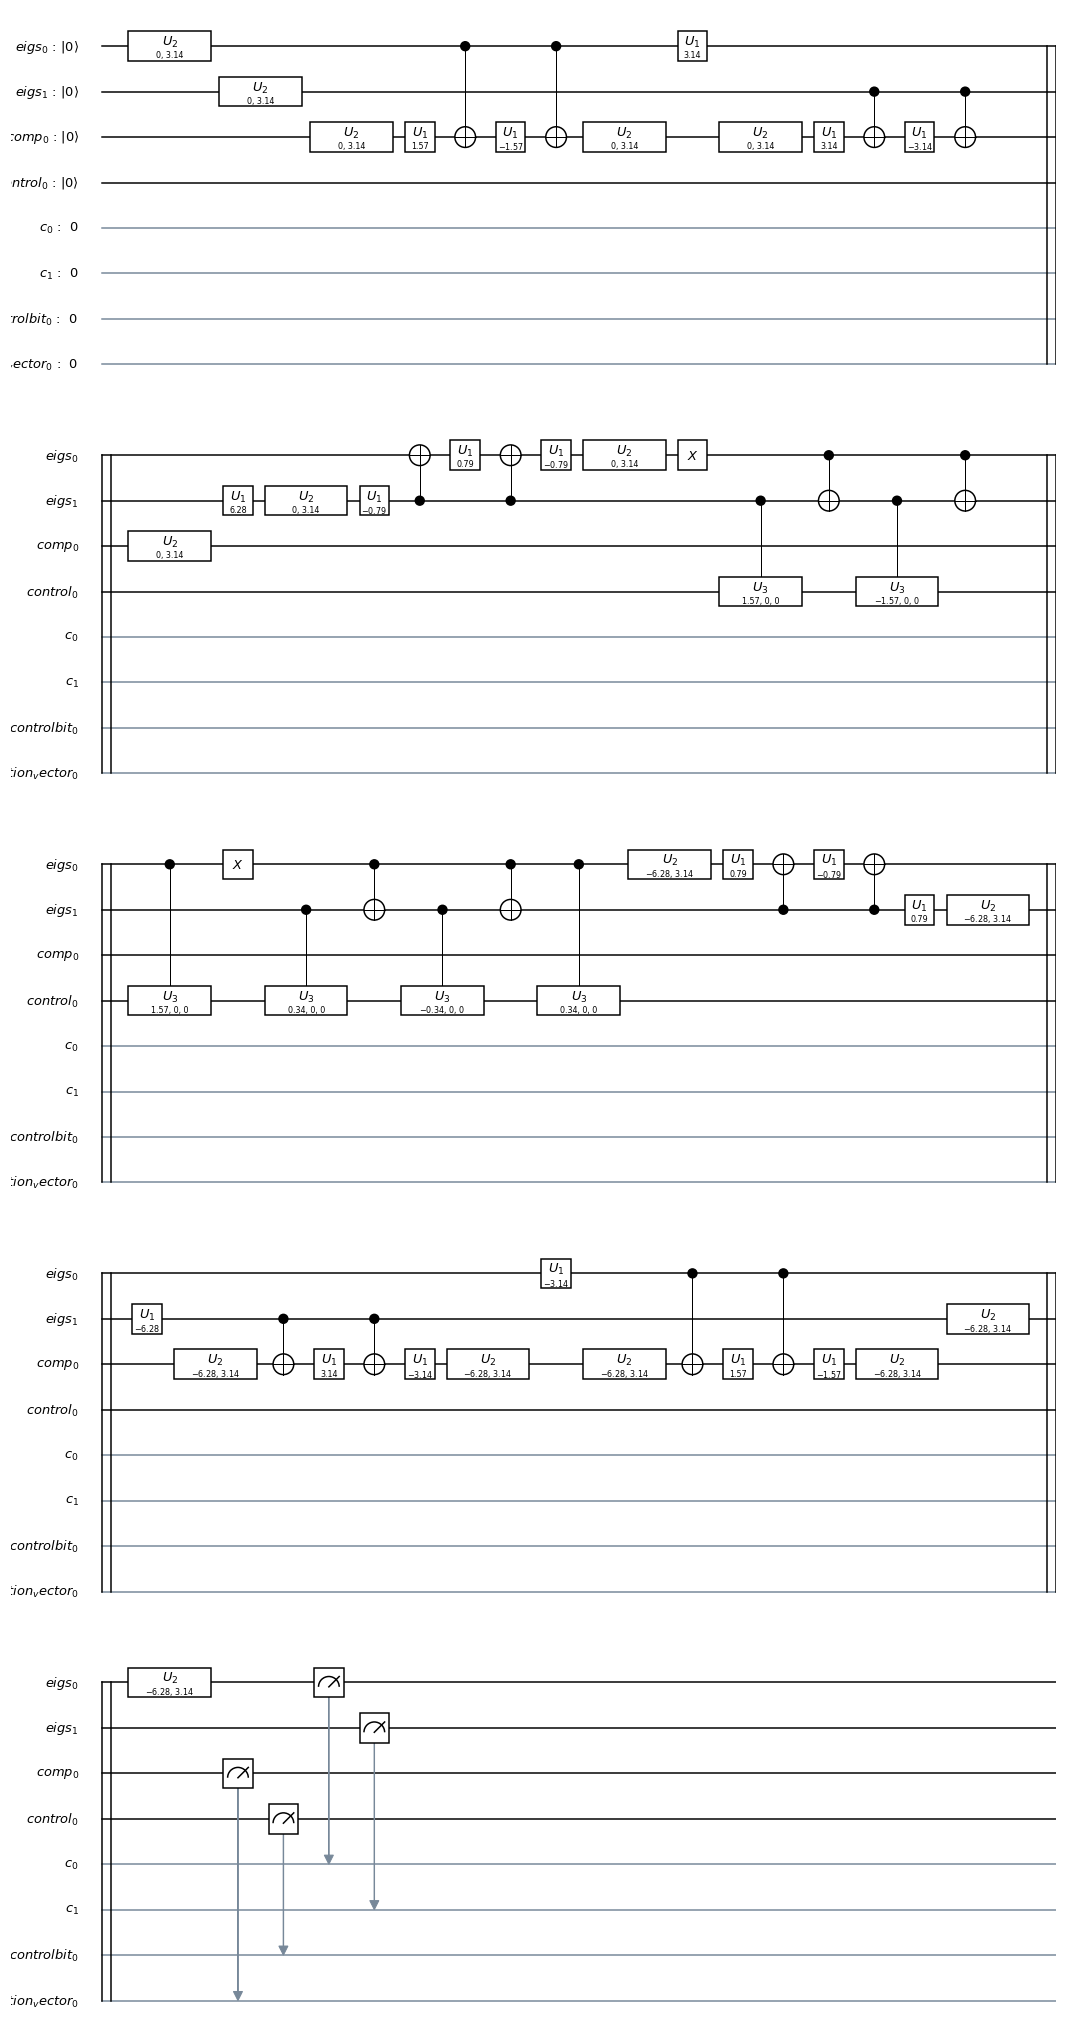

In [39]:
add_measurement_gates(qc)
matplotlib_circuit_drawer(qc)

We are ready to run our HHL program! 

In [40]:
result = execute(qc, backend=backend, shots=8024).result()
print(result.get_counts())

{'0 0 00': 1758, '0 1 00': 3591, '1 0 00': 1754, '1 1 00': 921}


In [41]:
N0 = result.get_counts(qc)['1 1 00']
N1 = result.get_counts(qc)['0 1 00']
print(N1/N0)

3.8990228013029316


The ratio of N0 and N1, i.e. the  relative probability of measuring 1, 0 respectively in the solution vector qubit, gives us the relative scale of the two entries in the vector.

Lets repeat our program several times to obtain better statistics... 

In [42]:
matrix =generate_matrix()
w, v = np.linalg.eigh(matrix) 

print(matrix)
print("Eigenvalues:", w)

#use one of 1/np.sqrt(2)*np.array([1,1]),[1,0],[0,1]
invec =  [1,0]

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,
            'evo_time': 2*np.pi/4,
            
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

[[ 2 -1]
 [-1  2]]
Eigenvalues: [1. 3.]


In [43]:
N0 = 0
N1 = 0
for i in range(10):
    qpe = QPE()


    qpe.init_params(params, matrix)

    qc = qpe._setup_qpe(measure=False)
    c1 = ClassicalRegister(1, name='controlbit')
    c2 = ClassicalRegister(N_sv, name='solution_vector')
    c = ClassicalRegister(2, name='c')
    qc.add(c)
    qc.add(c1)
    qc.add(c2)
    add_eigenvalue_inversion(qc)
    qc += qpe._construct_inverse()
    add_measurement_gates(qc)
    result = execute(qc, backend=backend, shots=8100).result()
    
    try:
        N0 = N0 + result.get_counts(qc)['1 1 00']
    except:
        pass
    try:
        N1 = N1 + result.get_counts(qc)['0 1 00']
    except:
        pass
    
    

QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.
QPE circuit qasm length is roughly 29.


In [44]:
print_linsystem(matrix,np.sqrt(N1/N0),invec)
#you have to trust the jupyter notebook to show these ipython elements

## $\begin{pmatrix}2&-1\\-1&2\end{pmatrix}$$\begin{pmatrix}a_0\\0.5a_0\end{pmatrix}$$= \begin{pmatrix}1\\0\end{pmatrix}$

## $a_0 = 0.6666666666666666$

## Equation 0 gave a result of $\begin{pmatrix}0.6666666666666666\\0.3362932203250549\end{pmatrix}$

## Correct $\begin{pmatrix}0.6666666666666666\\0.3333333333333333\end{pmatrix}$

## Real device
Now let's execute our quantum program on an IBM Q System. We are using only 4 qubits, so both the 5 qubit and the 16 qubit computers can be utilized.

In [ ]:
matrix =generate_matrix()
w, v = np.linalg.eigh(matrix) 
backend = least_busy(available_backends({'local': False, 'simulator': False}))#
print(matrix)
print("Eigenvalues:", w)

#use one of 1/np.sqrt(2)*np.array([1,1]),[1,0],[0,1]
invec =  [0,1]

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,
            'evo_time': 2*np.pi/4,
            
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}
print("Selected backend:",backend)

In [ ]:
N0_realdev = 0
N1_realdev = 0
for i in range(3):
    qpe = QPE()


    qpe.init_params(params, matrix)

    qc = qpe._setup_qpe(measure=False)
    c1 = ClassicalRegister(1, name='controlbit')
    c2 = ClassicalRegister(N_sv, name='solution_vector')
    c = ClassicalRegister(2, name='c')
    qc.add(c)
    qc.add(c1)
    qc.add(c2)
    add_eigenvalue_inversion(qc)
    qc += qpe._construct_inverse()
    add_measurement_gates(qc)
    result = execute(qc, backend=backend, shots=3000).result()
    print(result.get_counts(qc))
    try:
        N0_realdev = N0_realdev + result.get_counts(qc)['1 1 00']
    except:
        pass
    try:
        N1_realdev = N1_realdev + result.get_counts(qc)['0 1 00']
    except:
        pass
    print(result)
    

In [ ]:
print_linsystem(matrix,np.sqrt(N1_realdev/N0_realdev),invec)